# Get and clean School Demo. and Accountability Snapshot (2006-2012)

In this notebook, we get and clean the school demographics and accountability snapshot, 2006-2012. First, we read in the data from NYC Open Data. Then we:
1. Clean the data.
2. Imput school types (elementary, middle school, and/or high school)
3. Plot the distributions of several features in the snapshot.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

query = 'https://data.cityofnewyork.us/api/views/ihfw-zy9j/rows.csv?accessType=DOWNLOAD'
demo_and_account = pd.read_csv(query)

Before we proceed, lets take a quick look at the dataset:

In [93]:
pd.set_option('display.max_columns', 50)
demo_and_account.head(3)

DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   
2  01M015  P.S. 015 ROBERTO CLEMENTE    20072008       89.4          NaN   

   total_enrollment prek   k grade1 grade2 grade3 grade4 grade5 grade6 grade7  \
0               281   15  36     40     33     38     52     29     38    NaN   
1               243   15  29     39     38     34     42     46    NaN    NaN   
2               261   18  43     39     36     38     47     40    NaN    NaN   

  grade8 grade9 grade10 grade11 grade12  ell_num  ell_percent  sped_num  \
0    NaN    NaN     NaN     NaN     NaN       36         12.8        57   
1    NaN    NaN     NaN     NaN     NaN       38         15.6        55   
2    NaN    NaN     NaN     NaN     NaN       52         19.9        60   

   sped_percent ctt_num selfcontained_num  asian_num  asian_per  black_num  \
0          20.3      25                 9         10        3.6         74   
1          22.6      19                15         18        7.4         68   
2          23.0      20                14         16        6.1         77   

   black_per  hispanic_num  hispanic_per  white_num  white_per  male_num  \
0       26.3           189          67.3          5        1.8       158   
1       28.0           153          63.0          4        1.6       140   
2       29.5           157          60.2          7        2.7       143   

   male_per  female_num  female_per  
0      56.2         123        43.8  
1      57.6         103        42.4  
2      54.8         118        45.2

Note that (besides DBN, Name, and schoolyear) all feature should be numeric. Moreover, note the following behavior (discovered in later analysis comparing fl_percent and frl_percent):

In [94]:
compare_relationship_fl_frl = demo_and_account.groupby('DBN')['fl_percent','frl_percent'].mean()
print compare_relationship_fl_frl.head(10)

        frl_percent
DBN                
01M015    94.133333
01M019    75.166667
01M020    95.566667
01M034    97.600000
01M056          NaN
01M063    81.766667
01M064    85.966667
01M110    59.966667
01M134    87.033333
01M137    85.766667


Since we only get means for frl_percent, we know there are incorrect values in fl_percent. Let's find them:

In [95]:
def find_bad_vals(feature):
    bad_vals = {}
    for val in demo_and_account[feature].astype(str):
        finder = re.match('[0-9]+\.?[0-9]*', val)
        if finder == None:
            if val in bad_vals:
                bad_vals[val] += 1
            else:
                bad_vals[val] = 1
    return bad_vals

fl_percent_bad_vals = find_bad_vals('fl_percent')
print 'Bad values are: ', fl_percent_bad_vals

Bad values are:  {'   ': 2973, 'nan': 1509, 'n/a': 6}


Now we know the issue- there are 6 occurances of 'n/a'. Let's replace them:

In [96]:
demo_and_account.loc[demo_and_account['fl_percent'].astype(str).isin(fl_percent_bad_vals.keys()), 'fl_percent'] = np.NaN

Let's double check we've been able to replace all the bad values:

In [97]:
fl_percent_bad_vals = find_bad_vals('fl_percent')
print 'Bad values are: ', fl_percent_bad_vals

Bad values are:  {'nan': 4488}


Since we want all the features except DBN and name to be numeric, let's clean them all up using this function.

In [98]:
for feature in demo_and_account.drop(['Name','DBN','schoolyear'],axis=1).columns:
    demo_and_account.loc[(demo_and_account[feature].isin(find_bad_vals(feature).keys())),feature] = np.NaN
    demo_and_account[feature] =  demo_and_account[feature].astype(float)

In [99]:
demo_and_account.drop(['Name','DBN','schoolyear'],axis=1).describe()

fl_percent  frl_percent  total_enrollment         prek            k  \
count  5587.000000  4482.000000      10075.000000  3762.000000  5134.000000   
mean     67.535207    74.319232        676.251712    39.283626    94.120569   
std      21.763927    20.199703        571.479380    18.511524    47.433673   
min       1.600000     3.700000          1.000000     6.000000     1.000000   
25%      59.300000    65.000000        362.000000    29.000000    60.000000   
50%      72.300000    79.900000        534.000000    36.000000    86.000000   
75%      83.900000    89.200000        804.500000    52.000000   119.000000   
max     100.000000   100.000000       5332.000000   143.000000   361.000000   

            grade1       grade2       grade3       grade4       grade5  \
count  5129.000000  5087.000000  5001.000000  4948.000000  4986.000000   
mean    101.718854   100.453509   100.317337   100.275869    98.842760   
std      49.938692    48.813570    48.659580    48.347373    48.408357   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%      66.000000    65.000000    65.000000    65.000000    64.000000   
50%      94.000000    92.000000    92.000000    92.000000    91.000000   
75%     128.000000   127.000000   127.000000   127.000000   126.000000   
max     368.000000   369.000000   377.000000   390.000000   398.000000   

            grade6       grade7       grade8       grade9      grade10  \
count  3512.000000  3180.000000  3054.000000  2923.000000  2791.000000   
mean    139.792141   157.489937   167.272102   237.966815   225.161591   
std     118.138580   136.790459   145.600716   302.902117   270.825282   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%      66.000000    68.000000    69.000000    92.000000    89.000000   
50%      95.000000    98.000000   101.000000   124.000000   117.000000   
75%     163.000000   204.000000   232.000000   208.000000   195.000000   
max     812.000000   814.000000   824.000000  2005.000000  2016.000000   

           grade11      grade12      ell_num  ell_percent     sped_num  \
count  2599.000000  2422.000000  9885.000000  9963.000000  9985.000000   
mean    168.572143   162.713047    94.109863    13.419181    93.055684   
std     198.589398   191.417776   128.543858    14.074310    71.553037   
min       1.000000     1.000000     0.000000     0.000000     0.000000   
25%      69.000000    63.000000    19.000000     4.000000    49.000000   
50%      93.000000    87.000000    47.000000     9.200000    80.000000   
75%     155.000000   160.000000   119.000000    18.300000   118.000000   
max    1319.000000  1341.000000  1418.000000   100.000000   751.000000   

       sped_percent      ctt_num  selfcontained_num     asian_num  \
count  10075.000000  8666.000000        9063.000000  10075.000000   
mean      14.595325    26.426379          37.329692     99.564864   
std        6.632116    23.854651          37.613647    216.198496   
min        0.000000     0.000000           0.000000      0.000000   
25%       10.500000     8.000000          12.000000      4.000000   
50%       14.300000    21.000000          29.000000     16.000000   
75%       18.400000    38.000000          50.000000     89.000000   
max      100.000000   258.000000         440.000000   3214.000000   

          asian_per     black_num     black_per  hispanic_num  hispanic_per  \
count  10075.000000  10075.000000  10075.000000  10075.000000  10075.000000   
mean      10.975434    204.336576     34.606392    267.675335     41.026303   
std       16.548657    242.231283     28.474049    282.473135     25.745743   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000     50.000000     10.200000     81.000000     17.400000   
50%        3.300000    127.000000     27.500000    186.000000     38.400000   
75%       13.200000    267.000000     54.500000    348.000000     62.600000   
max       93.700000   3852.000000    100.

Next, let's drop the first two characters (district code) from the DBN (so DBN can be used as a merge key with our other datasets), and drop all but the last four characters from school year (so it can also be used as a merge key).

In [100]:
demo_and_account.loc[:,'DBN'] = demo_and_account['DBN'].map(lambda x: str(x)[2:])
demo_and_account.loc[:,'schoolyear'] = demo_and_account['schoolyear'].map(lambda x: str(x)[-4:])
demo_and_account.head(3)

DBN                       Name schoolyear  fl_percent  frl_percent  \
0  M015  P.S. 015 ROBERTO CLEMENTE       2006        89.4          NaN   
1  M015  P.S. 015 ROBERTO CLEMENTE       2007        89.4          NaN   
2  M015  P.S. 015 ROBERTO CLEMENTE       2008        89.4          NaN   

   total_enrollment  prek   k  grade1  grade2  grade3  grade4  grade5  grade6  \
0               281    15  36      40      33      38      52      29      38   
1               243    15  29      39      38      34      42      46     NaN   
2               261    18  43      39      36      38      47      40     NaN   

   grade7  grade8  grade9  grade10  grade11  grade12  ell_num  ell_percent  \
0     NaN     NaN     NaN      NaN      NaN      NaN       36         12.8   
1     NaN     NaN     NaN      NaN      NaN      NaN       38         15.6   
2     NaN     NaN     NaN      NaN      NaN      NaN       52         19.9   

   sped_num  sped_percent  ctt_num  selfcontained_num  asian_num  asian_per  \
0        57          20.3       25                  9         10        3.6   
1        55          22.6       19                 15         18        7.4   
2        60          23.0       20                 14         16        6.1   

   black_num  black_per  hispanic_num  hispanic_per  white_num  white_per  \
0         74       26.3           189          67.3          5        1.8   
1         68       28.0           153          63.0          4        1.6   
2         77       29.5           157          60.2          7        2.7   

   male_num  male_per  female_num  female_per  
0       158      56.2         123        43.8  
1       140      57.6         103        42.4  
2       143      54.8         118        45.2

Now let's drop the '_num' features, which are redundant (given the '_per' features).

In [101]:
demo_and_account.drop(['ell_num','sped_num','ctt_num','selfcontained_num','asian_num','black_num','hispanic_num','white_num','male_num','female_num'], axis=1, inplace=True)

In [102]:
demo_and_account.count()

DBN                 10075
Name                10075
schoolyear          10075
fl_percent           5587
frl_percent          4482
total_enrollment    10075
prek                 3762
k                    5134
grade1               5129
grade2               5087
grade3               5001
grade4               4948
grade5               4986
grade6               3512
grade7               3180
grade8               3054
grade9               2923
grade10              2791
grade11              2599
grade12              2422
ell_percent          9963
sped_percent        10075
asian_per           10075
black_per           10075
hispanic_per        10075
white_per           10075
male_per            10075
female_per          10075
dtype: int64

Next, we deal with the grade level counts (which we assume are missing values if no students were enrolled in that grade in a given school for a given year). We fill these missing valeus with zeros, then check that in fact the sum of the grade level counts then equals the total_enrollment.

In [103]:
for feature in ['prek','k','grade1','grade2','grade3','grade4','grade5','grade6','grade7','grade8','grade9','grade10','grade11','grade12']:
    demo_and_account[feature].fillna(0,inplace=True)
demo_and_account.count()

DBN                 10075
Name                10075
schoolyear          10075
fl_percent           5587
frl_percent          4482
total_enrollment    10075
prek                10075
k                   10075
grade1              10075
grade2              10075
grade3              10075
grade4              10075
grade5              10075
grade6              10075
grade7              10075
grade8              10075
grade9              10075
grade10             10075
grade11             10075
grade12             10075
ell_percent          9963
sped_percent        10075
asian_per           10075
black_per           10075
hispanic_per        10075
white_per           10075
male_per            10075
female_per          10075
dtype: int64

In [104]:
demo_and_account['total_check'] = demo_and_account['prek'] + demo_and_account['k'] + demo_and_account['grade1'] + demo_and_account['grade2'] + demo_and_account['grade3'] + demo_and_account['grade4'] + demo_and_account['grade5'] + demo_and_account['grade6'] + demo_and_account['grade7'] + demo_and_account['grade8'] + demo_and_account['grade9'] + demo_and_account['grade10'] + demo_and_account['grade11'] + demo_and_account['grade12']   

In [105]:
(demo_and_account['total_enrollment'] == demo_and_account['total_check']).sum()

10074

In [106]:
demo_and_account[~(demo_and_account['total_enrollment'] == demo_and_account['total_check'])][['total_enrollment','total_check']]

total_enrollment  total_check
2633              1004         1003

Since this single record is only off by a single student, we ignore the error and drop total_check.  <b> Note we will also drop total_enrollment after using it to construct a couple other features, since this feature is (almost) linearly dependent on the grade level counts. </b>

In [107]:
demo_and_account.drop('total_check', axis=1, inplace=True)
demo_and_account.count()

DBN                 10075
Name                10075
schoolyear          10075
fl_percent           5587
frl_percent          4482
total_enrollment    10075
prek                10075
k                   10075
grade1              10075
grade2              10075
grade3              10075
grade4              10075
grade5              10075
grade6              10075
grade7              10075
grade8              10075
grade9              10075
grade10             10075
grade11             10075
grade12             10075
ell_percent          9963
sped_percent        10075
asian_per           10075
black_per           10075
hispanic_per        10075
white_per           10075
male_per            10075
female_per          10075
dtype: int64

Next, we deal with the schools missing ell_percent. To fill these missing values, we use mean inputation, (filling with the average ell_percent for that school for all other available years).

In [108]:
missing_ell = demo_and_account[demo_and_account.ell_percent.isnull()].groupby('DBN')
missing_ell.groups

{'K143': [5385],
 'K301': [4557],
 'K336': [4585, 4586],
 'K340': [5634, 5639],
 'K348': [6846],
 'K378': [5194],
 'K390': [5677],
 'K391': [5679],
 'K392': [7290, 7291, 7292, 7293],
 'K393': [5439],
 'K409': [6276],
 'K449': [4917, 4918],
 'K452': [6289],
 'K470': [5721],
 'K479': [5724],
 'K492': [4633, 4634],
 'K518': [7312, 7313],
 'K527': [4653],
 'K529': [5280],
 'K543': [5780, 5784, 5785],
 'K555': [7174, 7177],
 'K575': [4674, 4678],
 'K585': [7180, 7182],
 'K590': [5833],
 'K595': [4687],
 'K628': [5482, 5484],
 'K670': [4709, 4712],
 'K698': [5309],
 'M012': [1225, 1227],
 'M077': [297, 298],
 'M114': [322, 324, 325],
 'M150': [365],
 'M164': [1777],
 'M223': [1832],
 'M224': [1360],
 'M243': [1045, 1046, 1047],
 'M275': [1574],
 'M277': [1369],
 'M318': [1610],
 'M334': [1122],
 'M376': [552],
 'M411': [592],
 'M416': [619, 621],
 'M445': [693],
 'M519': [742],
 'M565': [819],
 'M692': [1669, 1670, 1673, 1674],
 'M696': [199],
 'Q180': [8389],
 'Q248': [9058],
 'Q284': [8782

In [109]:
avg_ell = {}
for group in missing_ell.groups:
    avg_ell[group] = demo_and_account[(demo_and_account.DBN == group)]['ell_percent'].mean()
print 'Number of schools missing ell_percent records:', len(pd.Series(avg_ell)), '\nNumber with defined means:', pd.Series(avg_ell).count()

Number of schools missing ell_percent records: 69 
Number with defined means: 66


For 66 of the schools, we are able to determine the mean ell_percent over the 7 years using at least one non-NaN observation. We will use this mean to impute the  missing records. Then, we drop the other three schools.

In [110]:
demo_and_account.loc[demo_and_account['ell_percent'].isnull(),'ell_percent'] = demo_and_account.loc[demo_and_account['ell_percent'].isnull(), 'DBN'].map(lambda x: avg_ell[x])
demo_and_account.count()

DBN                 10075
Name                10075
schoolyear          10075
fl_percent           5587
frl_percent          4482
total_enrollment    10075
prek                10075
k                   10075
grade1              10075
grade2              10075
grade3              10075
grade4              10075
grade5              10075
grade6              10075
grade7              10075
grade8              10075
grade9              10075
grade10             10075
grade11             10075
grade12             10075
ell_percent         10072
sped_percent        10075
asian_per           10075
black_per           10075
hispanic_per        10075
white_per           10075
male_per            10075
female_per          10075
dtype: int64

Note since we are missing only three records for ell_percent, we know these schools were only present for one of seven possible years in the dataset. Thus, they don't represent a significant portion of the NYC school system so we drop them.

In [111]:
demo_and_account = demo_and_account.loc[demo_and_account['ell_percent'].notnull(),:]
demo_and_account.count()

DBN                 10072
Name                10072
schoolyear          10072
fl_percent           5584
frl_percent          4482
total_enrollment    10072
prek                10072
k                   10072
grade1              10072
grade2              10072
grade3              10072
grade4              10072
grade5              10072
grade6              10072
grade7              10072
grade8              10072
grade9              10072
grade10             10072
grade11             10072
grade12             10072
ell_percent         10072
sped_percent        10072
asian_per           10072
black_per           10072
hispanic_per        10072
white_per           10072
male_per            10072
female_per          10072
dtype: int64

Finally, we need to deal with the missing fl_percent and frl_percent values. Unfortunately, frl_percent is only available for academic years (AYs) between 2005-2006 and 2008-2009, while frl_percent is available for academic years between 2009-2010 and 2011-2012. We attempt to construct a measure of poverty that is comparable across years: poverty_level- that ranks a school's poverty level as a percentile using the available metric.

In [112]:
from scipy import stats
import numpy as np

demo_and_account.school = demo_and_account.schoolyear
grouped = demo_and_account.groupby('schoolyear')

for year in range(2006,2010):
    data = demo_and_account.loc[grouped.groups[str(year)],'fl_percent']
    demo_and_account.loc[grouped.groups[str(year)],'poverty_level'] = [stats.percentileofscore(data, a, 'weak') for a in data]
    
for year in range(2010,2013):
    data = demo_and_account.loc[grouped.groups[str(year)],'frl_percent']
    demo_and_account.loc[grouped.groups[str(year)],'poverty_level'] = [stats.percentileofscore(data, a, 'weak') for a in data]

In [113]:
demo_and_account.describe()

fl_percent  frl_percent  total_enrollment          prek             k  \
count  5584.000000  4482.000000      10072.000000  10072.000000  10072.000000   
mean     67.535064    74.319232        676.452740     14.672855     47.976072   
std      21.760585    20.199703        571.445742     22.116016     57.972498   
min       1.600000     3.700000          1.000000      0.000000      0.000000   
25%      59.300000    65.000000        362.000000      0.000000      0.000000   
50%      72.300000    79.900000        535.000000      0.000000     26.000000   
75%      83.900000    89.200000        805.000000     33.000000     87.000000   
max     100.000000   100.000000       5332.000000    143.000000    361.000000   

             grade1        grade2        grade3        grade4        grade5  \
count  10072.000000  10072.000000  10072.000000  10072.000000  10072.000000   
mean      51.798650     50.735405     49.809968     49.261815     48.930600   
std       62.095878     61.041372     60.758219     60.510230     60.020147   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       27.000000     23.000000      0.000000      0.000000      0.000000   
75%       95.000000     92.000000     91.000000     91.000000     90.000000   
max      368.000000    369.000000    377.000000    390.000000    398.000000   

             grade6        grade7        grade8        grade9       grade10  \
count  10072.000000  10072.000000  10072.000000  10072.000000  10072.000000   
mean      48.744043     49.723689     50.719619     69.060465     62.393368   
std       96.458036    106.139408    111.079703    195.668510    174.573840   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%       70.000000     63.000000     59.000000     74.000000     66.000000   
max      812.000000    814.000000    824.000000   2005.000000   2016.000000   

            grade11       grade12   ell_percent  sped_percent     asian_per  \
count  10072.000000  10072.000000  10072.000000  10072.000000  10072.000000   
mean      43.498709     39.127383     13.293473     14.589744     10.978703   
std      124.959062    116.808624     14.058451      6.575065     16.550037   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      3.900000     10.500000      1.000000   
50%        0.000000      0.000000      9.100000     14.300000      3.300000   
75%       26.000000      0.000000     18.200000     18.400000     13.200000   
max     1319.000000   1341.000000    100.000000     51.700000     93.700000   

          black_per  hispanic_per     white_per      male_per    female_per  \
count  10072.000000  10072.000000  10072.000000  10072.000000  10072.000000   
mean      34.606771     41.018666     12.209780     50.476807     49.523431   
std       28.466657     25.732914     19.333926      8.136714      8.136629   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       10.200000     17.400000      0.900000     48.500000     46.800000   
50%       27.500000     38.400000      2.400000     51.000000     49.000000   
75%       54.500000     62.525000     14.600000     53.200000     51.500000   
max      100.000000    100.000000    100.000000    100.000000    100.000000   

       poverty_level  
count   10072.000000  
mean       50.084984  
std        28.881728  
min         0.000000  
25%        25.051461  
50%        50.070922  
75%        75.022723  
max       100.000000

Now that we've dealt with all the missing values, we have two more tasks:
 - Determining the relationships between the race/ethnicity measures
 - Binning schools based on their enrollment by grade level
First, we explore the race/ethnicity measures:

In [114]:
test_race = demo_and_account['asian_per']+demo_and_account['black_per']+demo_and_account['white_per']+demo_and_account['hispanic_per']
print test_race.values.max()
print len(test_race[test_race>100])

100.1
195


So, of the 10,072 records, 195 have total race/ethnicity percentages of 100.1. This is not a problem, as these measures are not necessarily disjoint, but it is an important sanity check (i.e. it is suggestive the data is reliable since the total is not much above 100 for any school).

Now let's make dummy variables corresponding to the type of school. We're going to reduce the schools into three (non-exclusive) classes:
 - Elementary: At least 30% of the students are in grades prek-grade5
 - Middle School: At least 15% of the students are in grades grade6-grade8
 - High School: At least 30% of the students are in grades grade9-grade12 <br>
Again, these classes are non-exclusive because some schools contain larger grade ranges (i.e. prek-8, etc.) However, based on the pairwise distributions, we anticipate these categories will describe the majority of schools.

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)
sns.pairplot(demo_and_account[['prek', 'k', 'grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12']])

In [116]:
demo_and_account['elementary_school'] = ((demo_and_account['prek']+demo_and_account['k']+demo_and_account['grade1']+demo_and_account['grade2']+demo_and_account['grade3']+demo_and_account['grade4']+demo_and_account['grade5'])/demo_and_account['total_enrollment']).map(lambda x: 0 if x<0.3 else 1)
demo_and_account['middle_school'] = ((demo_and_account['grade6']+demo_and_account['grade7']+demo_and_account['grade8'])/demo_and_account['total_enrollment']).map(lambda x: 0 if x<0.15 else 1)
demo_and_account['high_school'] = ((demo_and_account['grade9']+demo_and_account['grade10']+demo_and_account['grade11']+demo_and_account['grade12'])/demo_and_account['total_enrollment']).map(lambda x: 0 if x<0.3 else 1)

In [117]:
len(demo_and_account[demo_and_account[['elementary_school','middle_school','high_school']].sum(axis=1) == 0])

0

In [118]:
type_counts = demo_and_account[['total_enrollment', 'elementary_school','middle_school','high_school']].groupby(['elementary_school','middle_school','high_school']).count()
type_counts.columns=['Number_of_schools_in_category']
type_counts

Number_of_schools_in_category
elementary_school middle_school high_school                               
0                 0             1                                     2452
                  1             0                                     1949
                                1                                      441
1                 0             0                                     4288
                  1             0                                      931
                                1                                       11

In [119]:
def validate_bins(a,b,c):
    validate = demo_and_account[pd.concat([demo_and_account['elementary_school']==a, demo_and_account['middle_school']==b, demo_and_account['high_school']==c], axis=1).all(axis=1)][['prek', 'k', 'grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12']]
    grades = ['prek', 'k', 'grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12']
    sns.pairplot(validate[grades])

In [120]:
validate_bins(0,0,1)

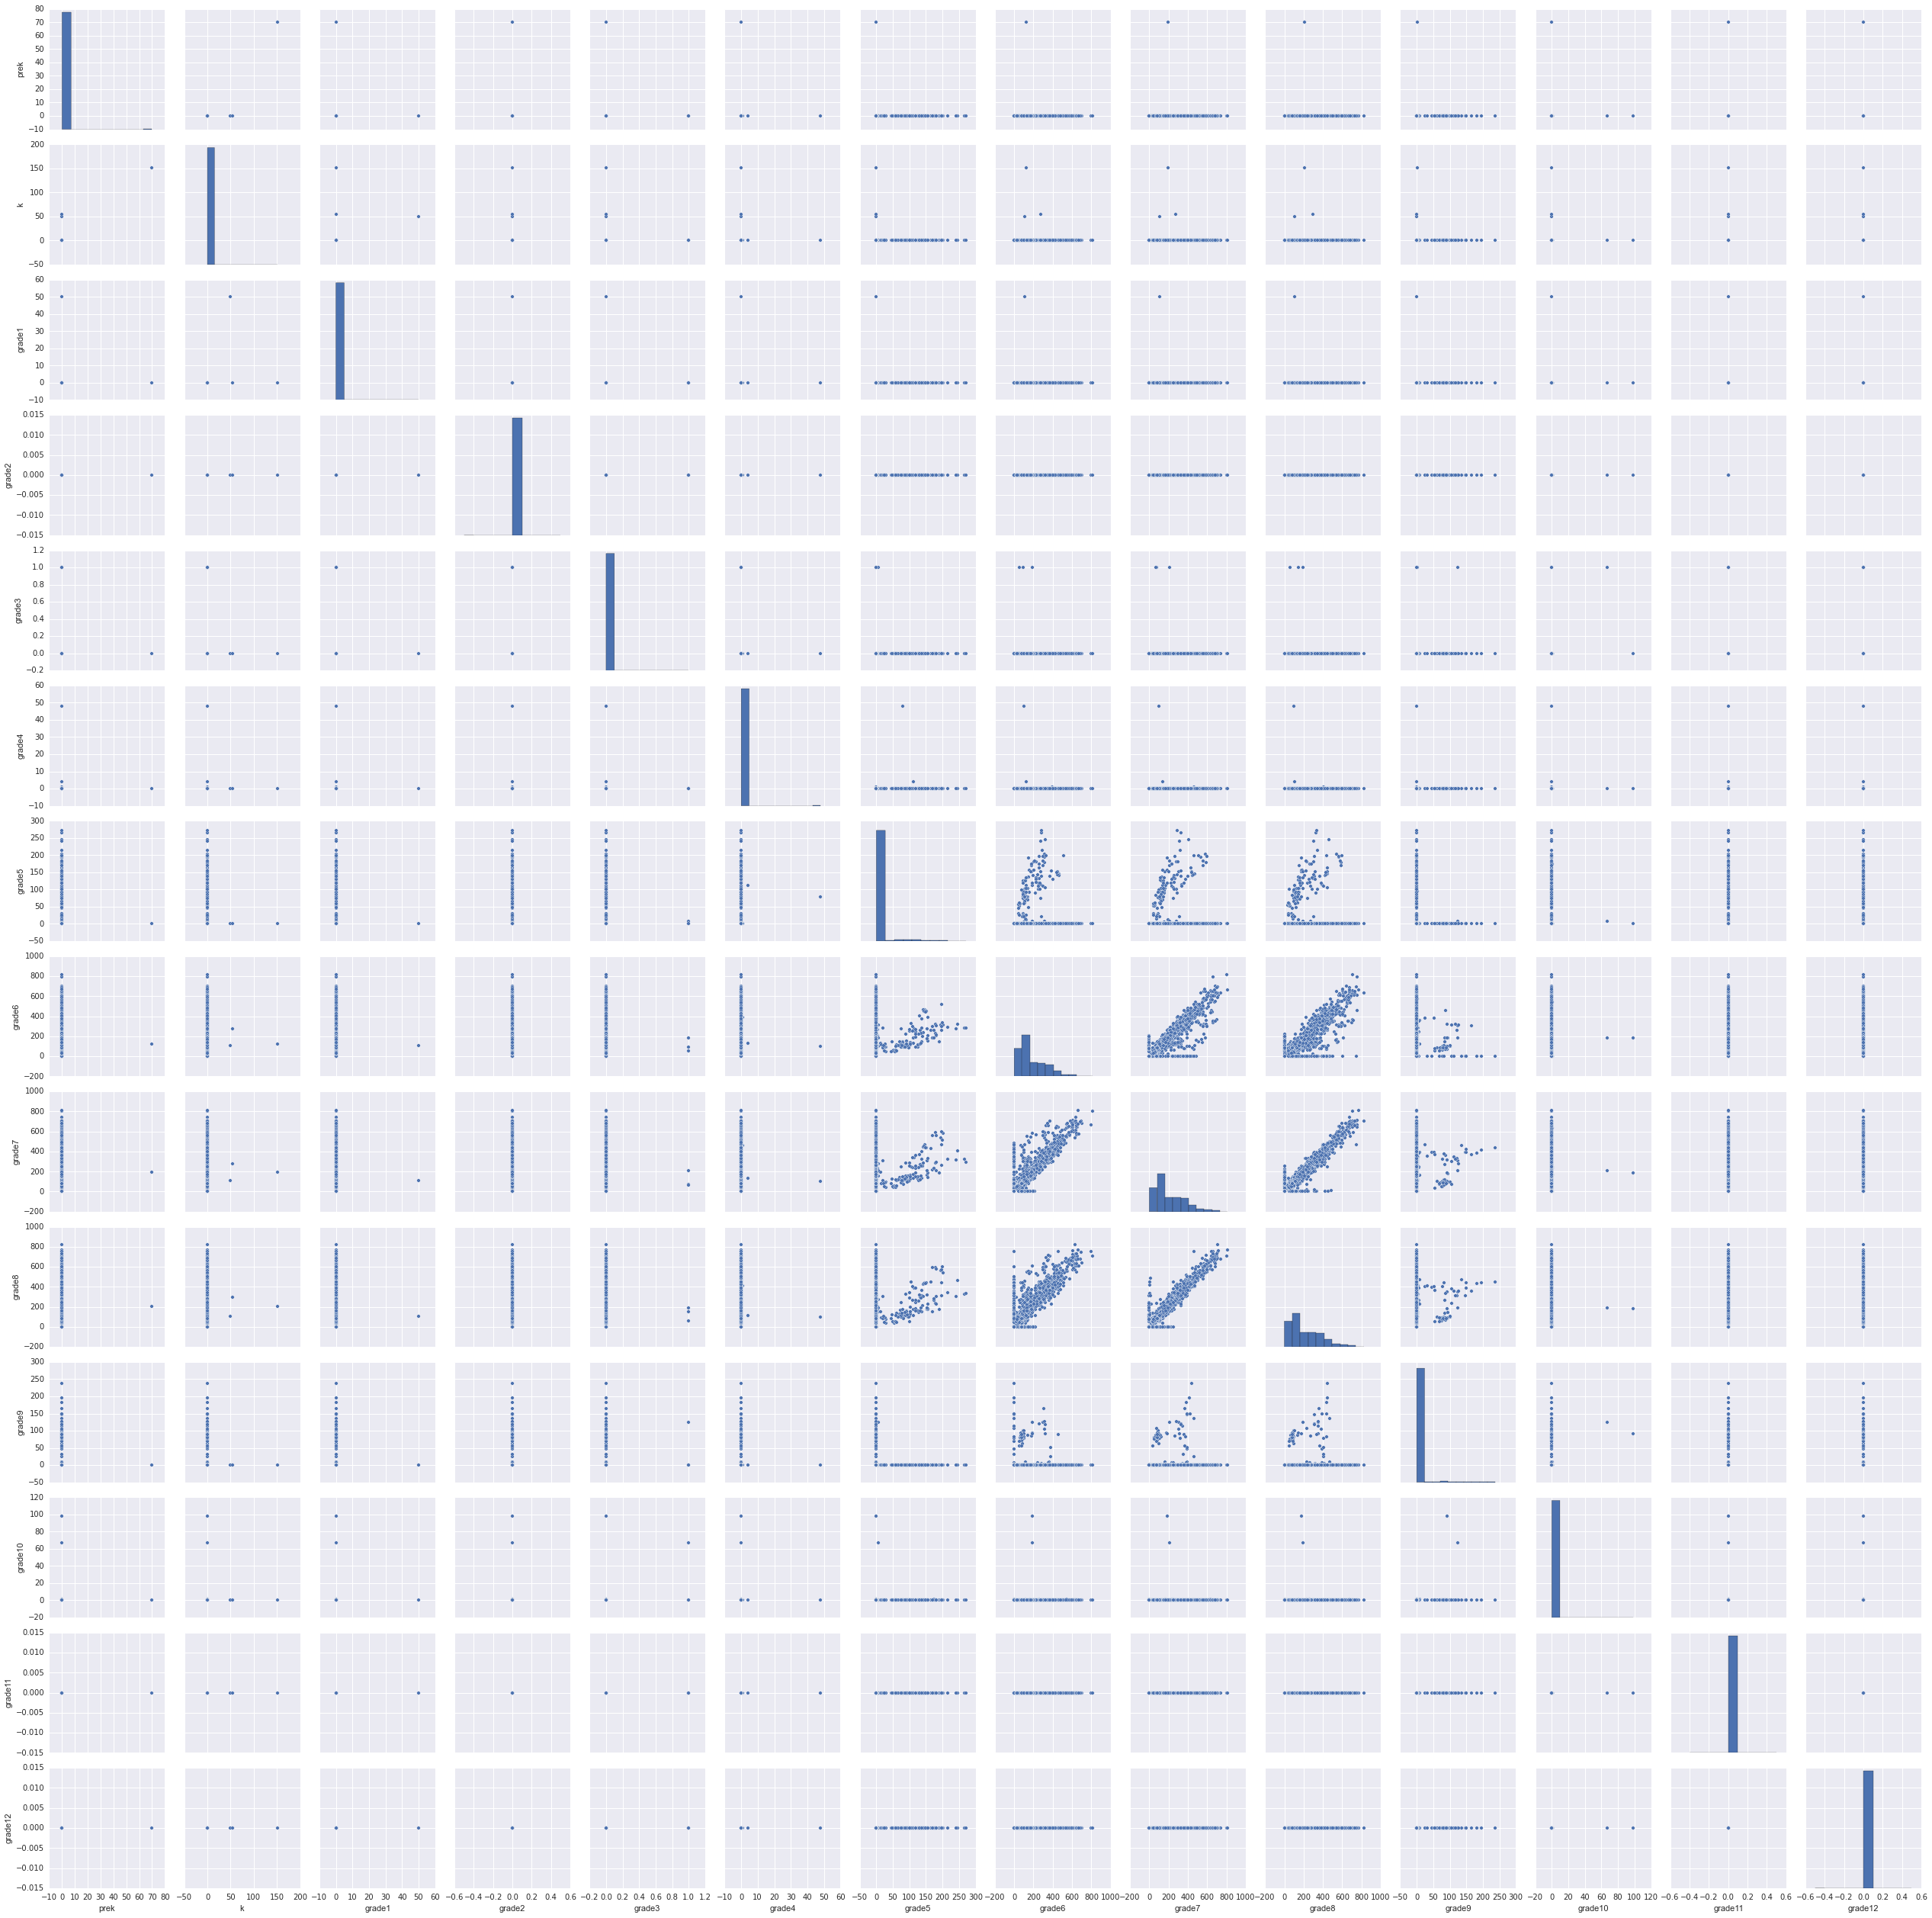

In [121]:
validate_bins(0,1,0)

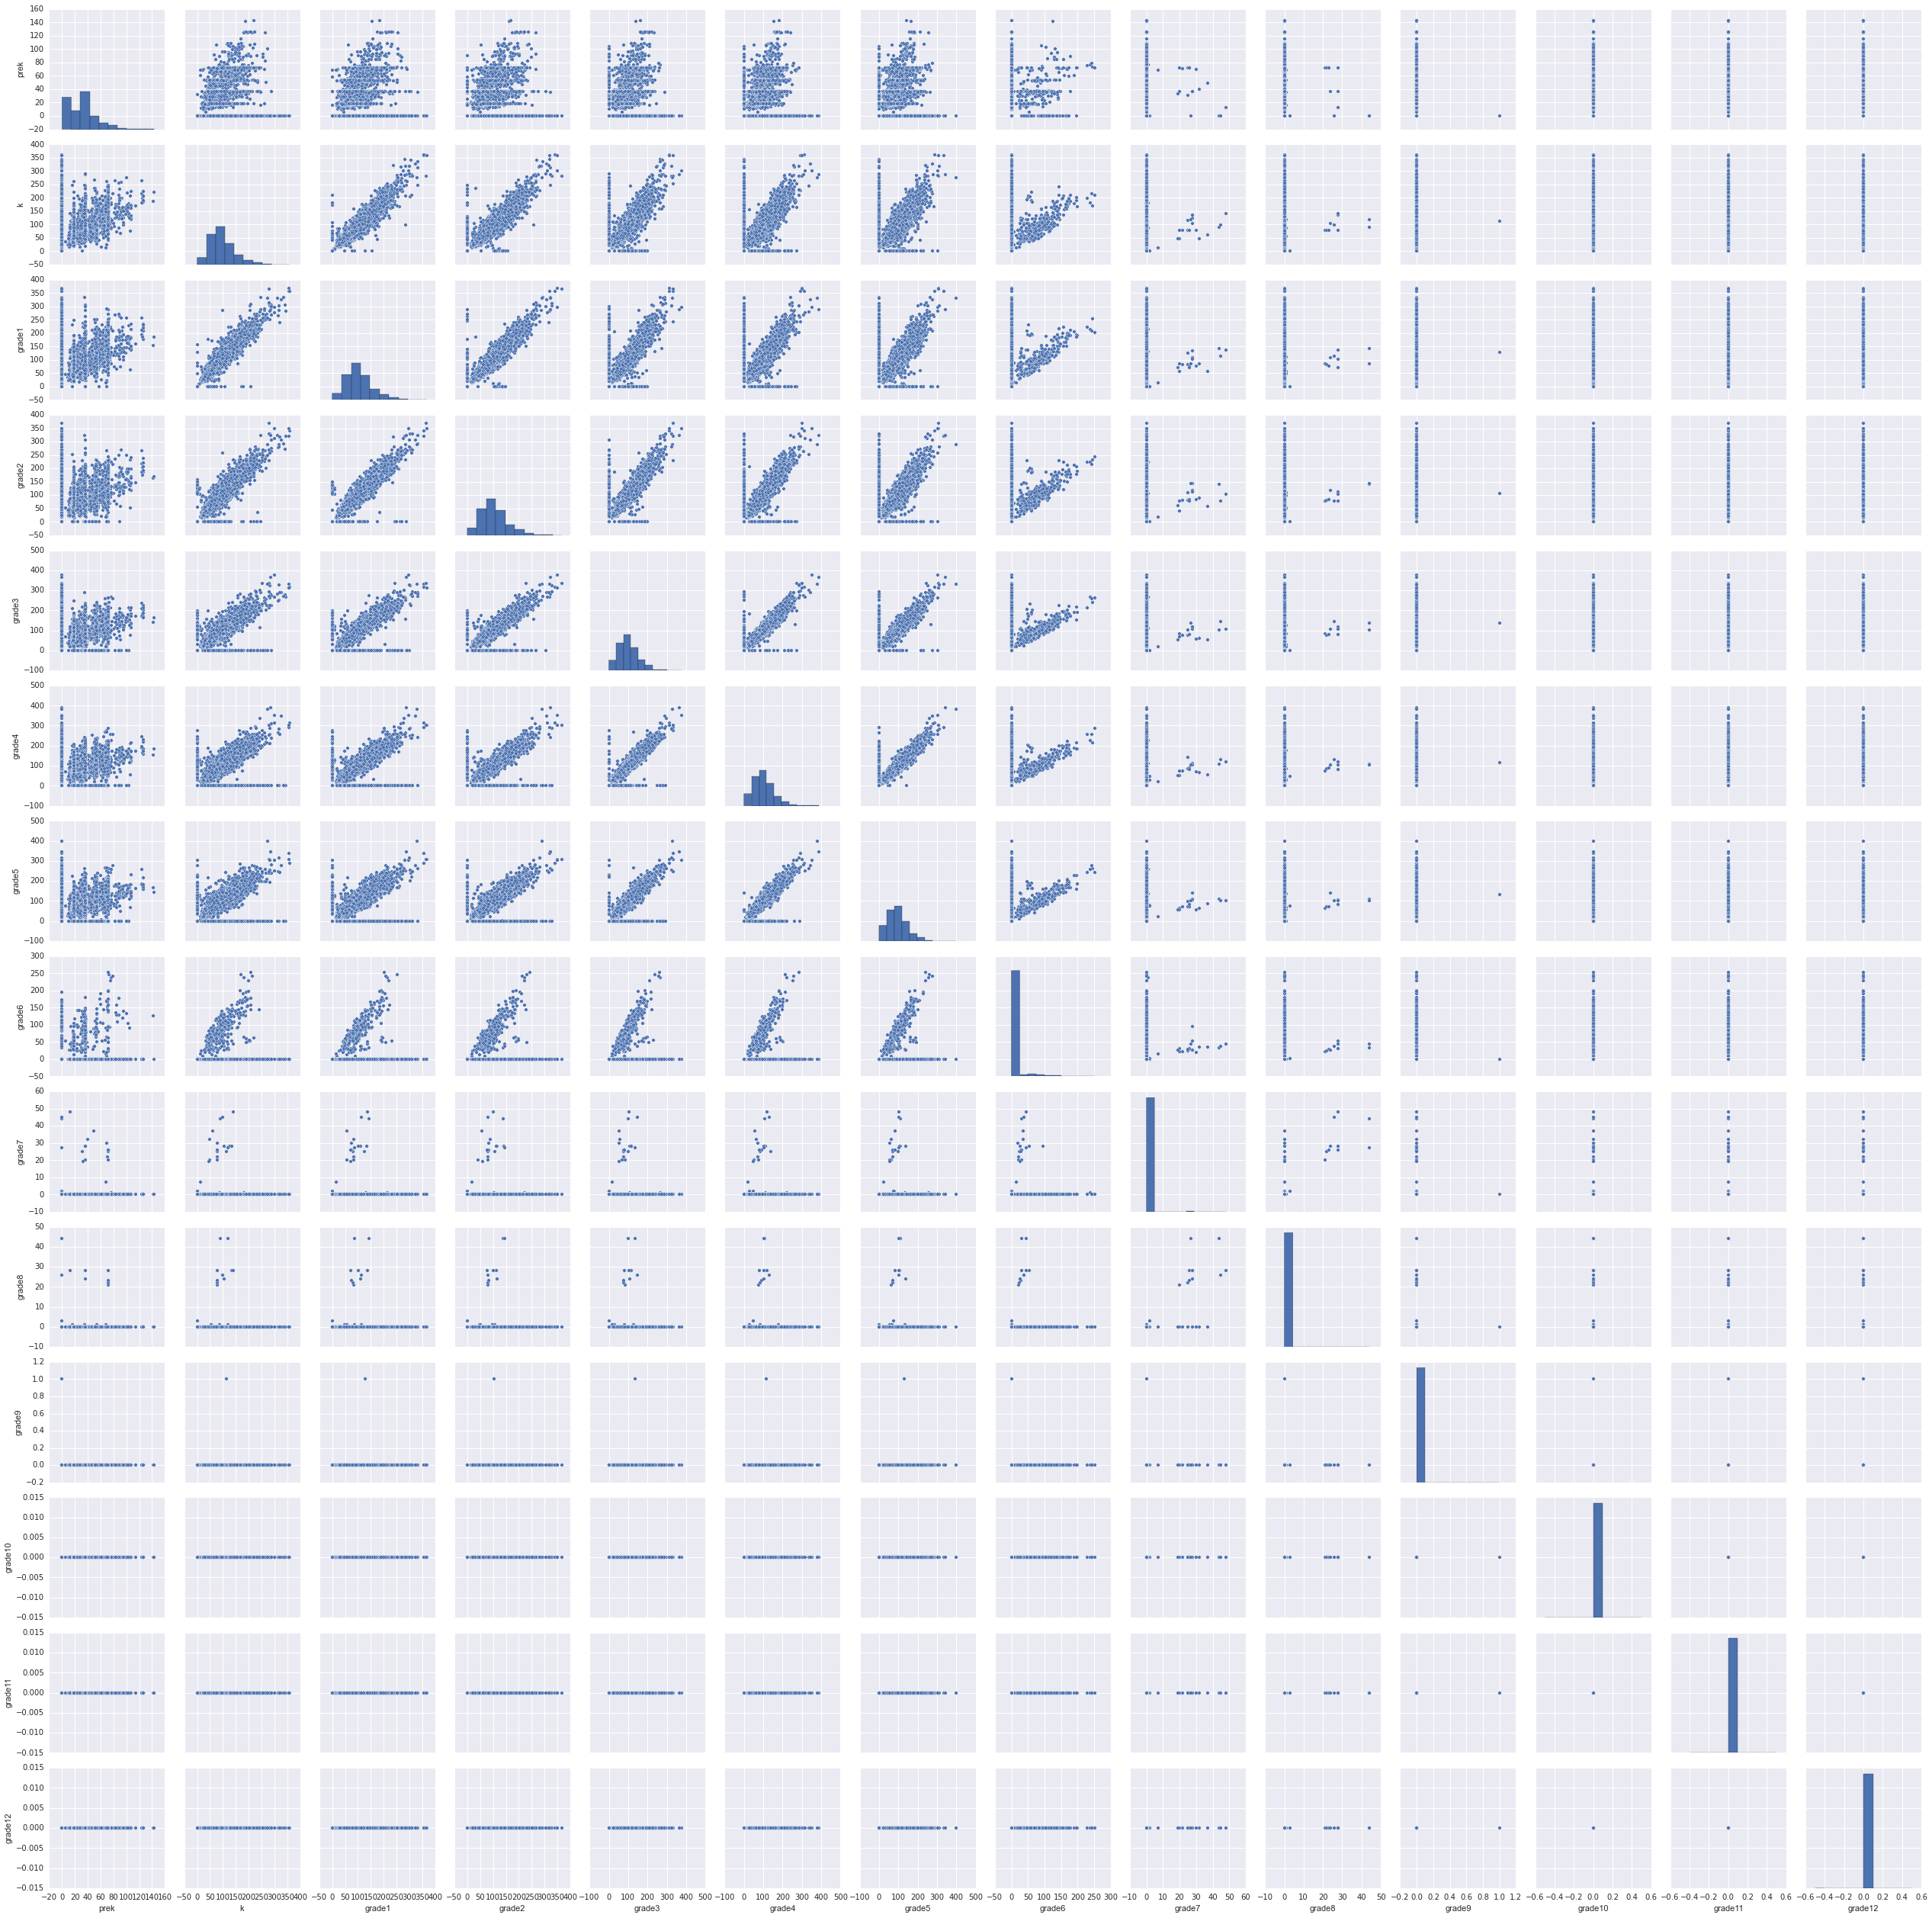

In [122]:
validate_bins(1,0,0)

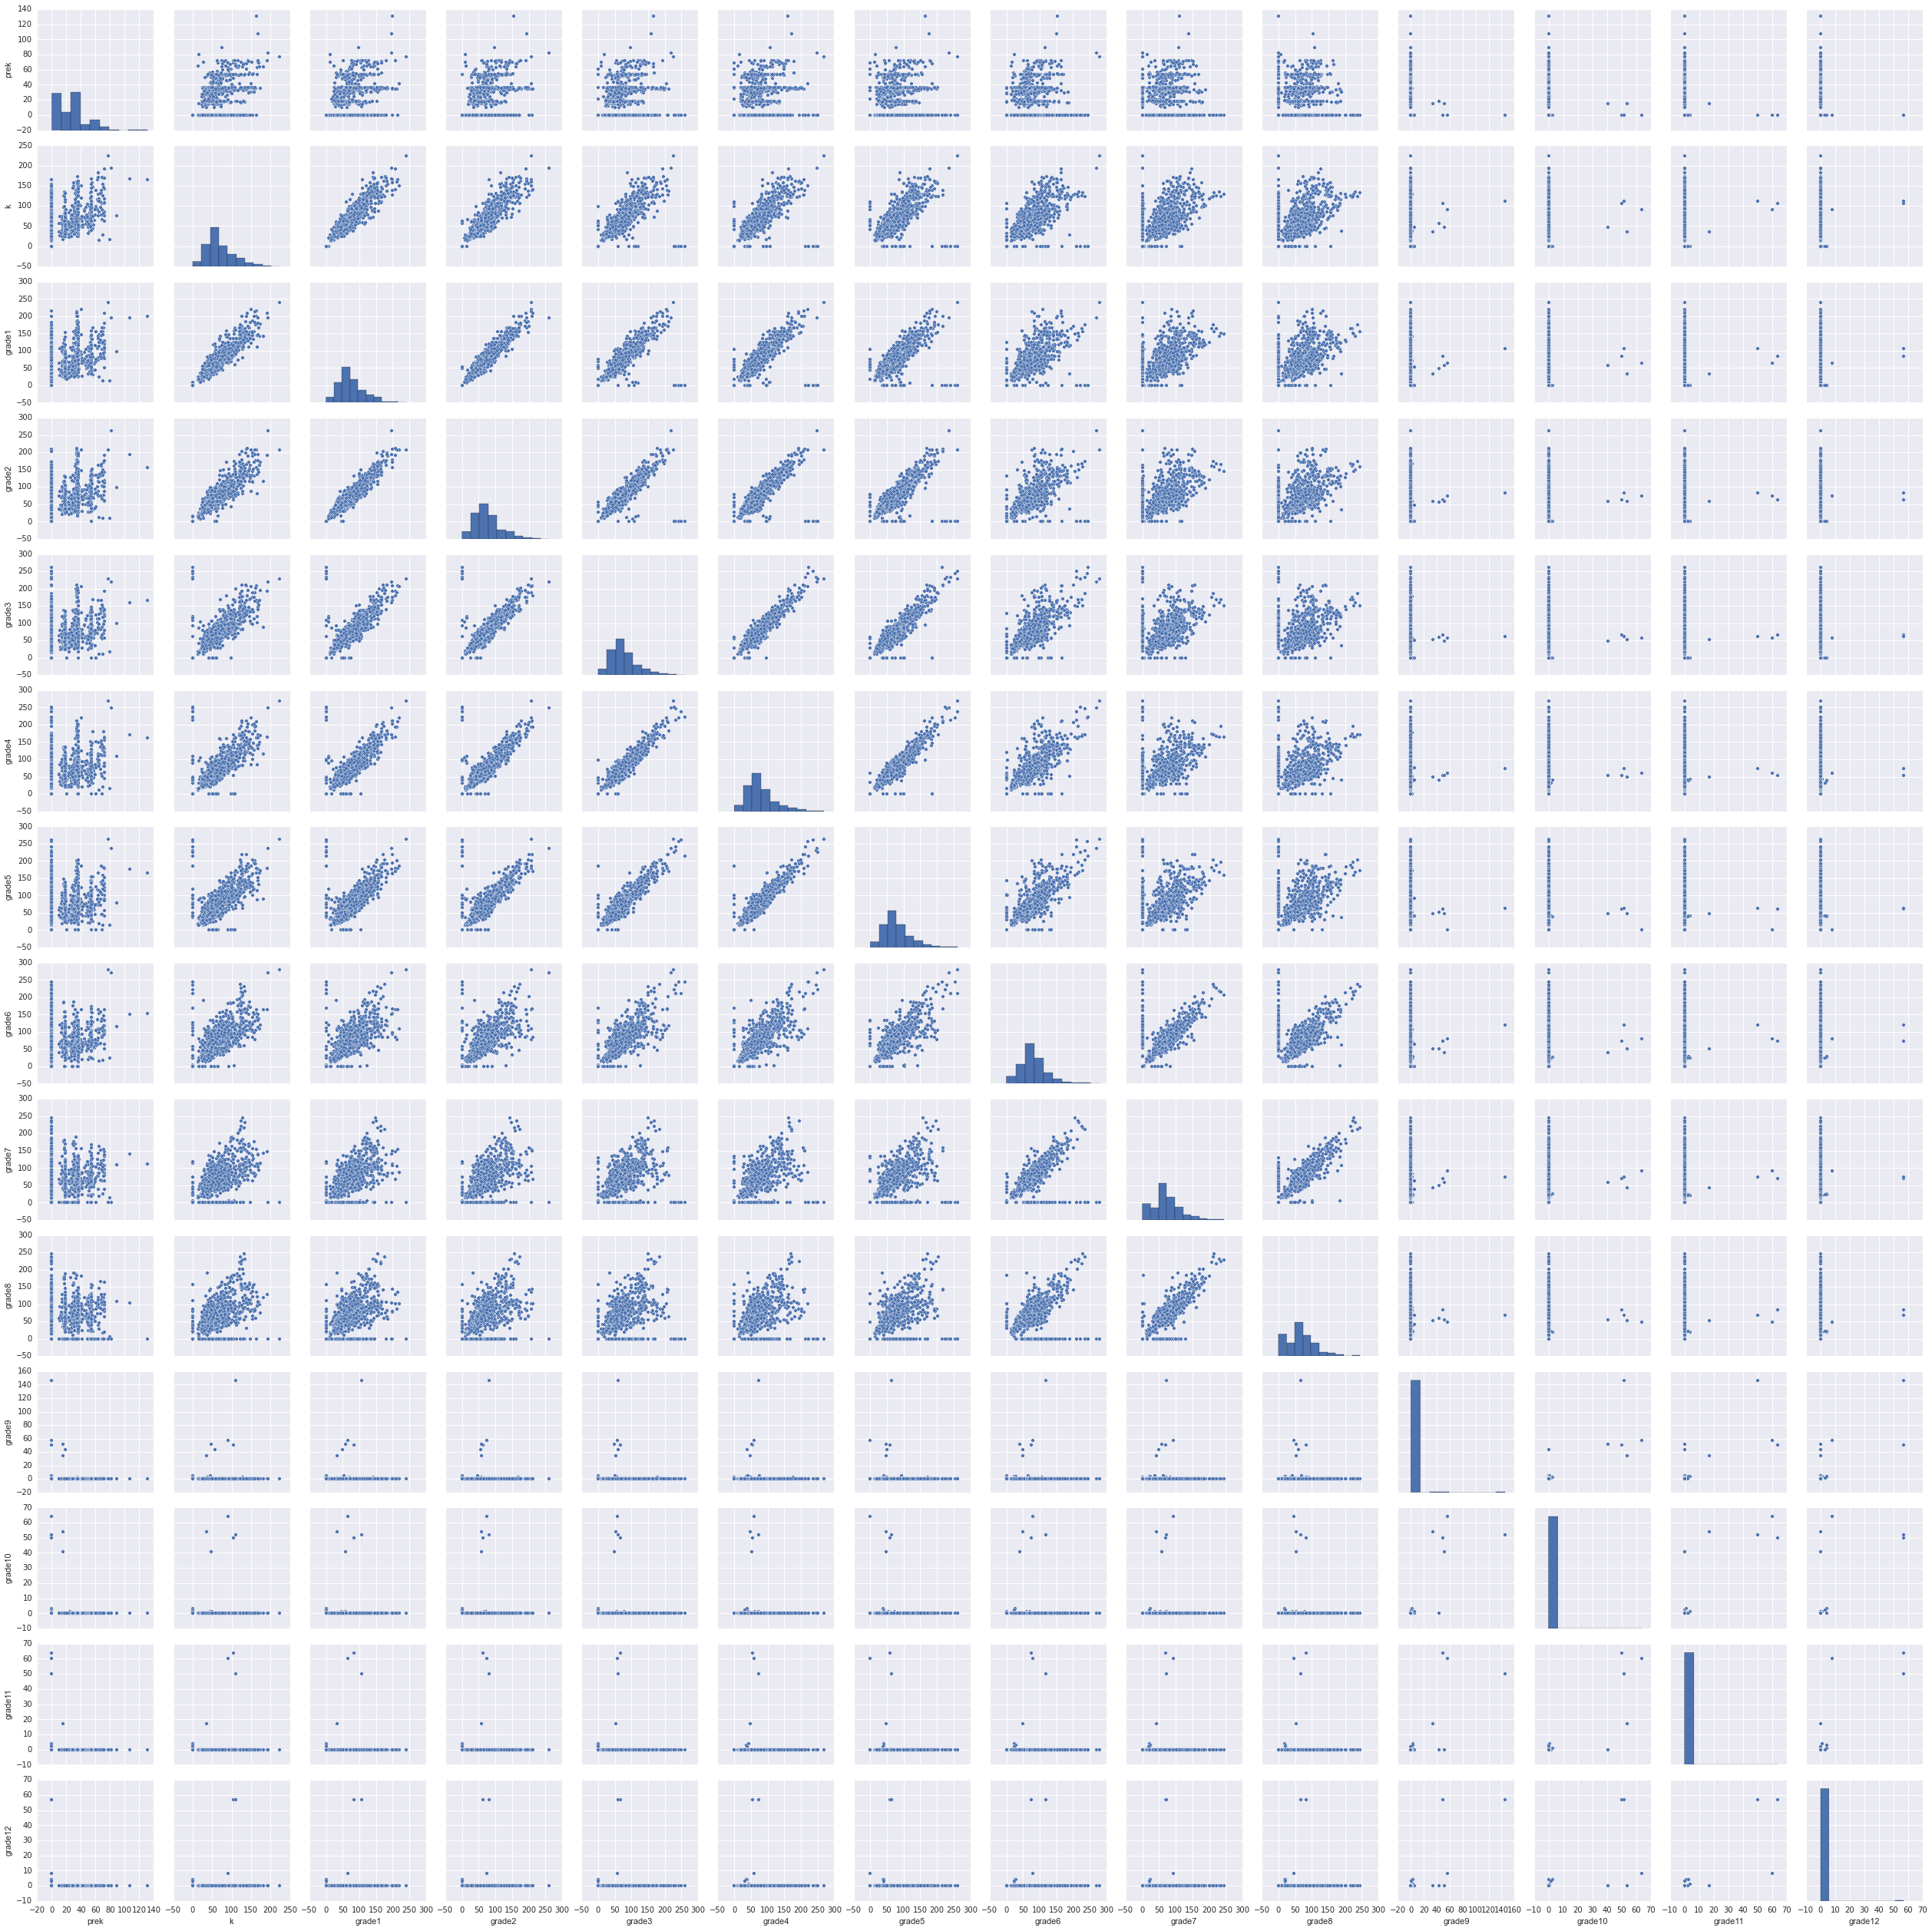

In [123]:
validate_bins(1,1,0)

In [124]:
validate_bins(1,1,1)

Now that we've classified each school, let's drop the individual grade-level measures:

In [125]:
demo_and_account.drop(['prek', 'k', 'grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12'], axis=1, inplace=True)
demo_and_account.describe()

fl_percent  frl_percent  total_enrollment   ell_percent  sped_percent  \
count  5584.000000  4482.000000      10072.000000  10072.000000  10072.000000   
mean     67.535064    74.319232        676.452740     13.293473     14.589744   
std      21.760585    20.199703        571.445742     14.058451      6.575065   
min       1.600000     3.700000          1.000000      0.000000      0.000000   
25%      59.300000    65.000000        362.000000      3.900000     10.500000   
50%      72.300000    79.900000        535.000000      9.100000     14.300000   
75%      83.900000    89.200000        805.000000     18.200000     18.400000   
max     100.000000   100.000000       5332.000000    100.000000     51.700000   

          asian_per     black_per  hispanic_per     white_per      male_per  \
count  10072.000000  10072.000000  10072.000000  10072.000000  10072.000000   
mean      10.978703     34.606771     41.018666     12.209780     50.476807   
std       16.550037     28.466657     25.732914     19.333926      8.136714   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000     10.200000     17.400000      0.900000     48.500000   
50%        3.300000     27.500000     38.400000      2.400000     51.000000   
75%       13.200000     54.500000     62.525000     14.600000     53.200000   
max       93.700000    100.000000    100.000000    100.000000    100.000000   

         female_per  poverty_level  elementary_school  middle_school  \
count  10072.000000   10072.000000       10072.000000   10072.000000   
mean      49.523431      50.084984           0.519261       0.330818   
std        8.136629      28.881728           0.499654       0.470531   
min        0.000000       0.000000           0.000000       0.000000   
25%       46.800000      25.051461           0.000000       0.000000   
50%       49.000000      50.070922           1.000000       0.000000   
75%       51.500000      75.022723           1.000000       1.000000   
max      100.000000     100.000000           1.000000       1.000000   

        high_school  
count  10072.000000  
mean       0.288324  
std        0.453005  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

Now let's do some exploratory analysis:

In [126]:
boys = plt.hist(demo_and_account.male_per, bins = 100, range=(0,100))
plt.title('Percent boys, by school, 2006-2012')

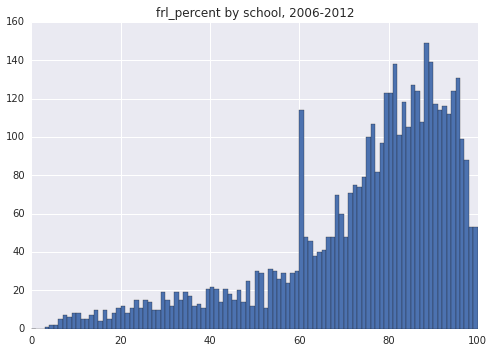

In [127]:
frl = plt.hist(demo_and_account.frl_percent, bins = 100, range=(0,100))
plt.title('frl_percent by school, 2006-2012')

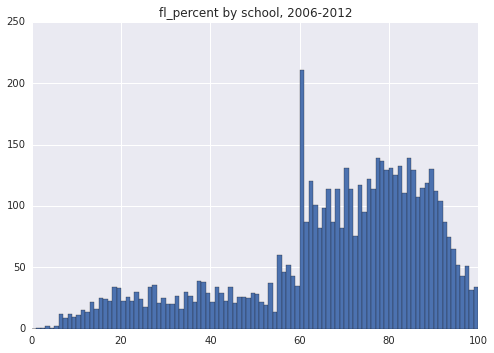

In [128]:
fl = plt.hist(demo_and_account.fl_percent, bins = 100, range=(0,100))
plt.title('fl_percent by school, 2006-2012')

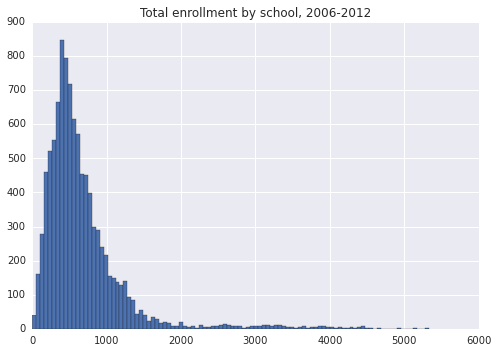

In [129]:
enrollment = plt.hist(demo_and_account.total_enrollment, bins = 100)
plt.title('Total enrollment by school, 2006-2012')

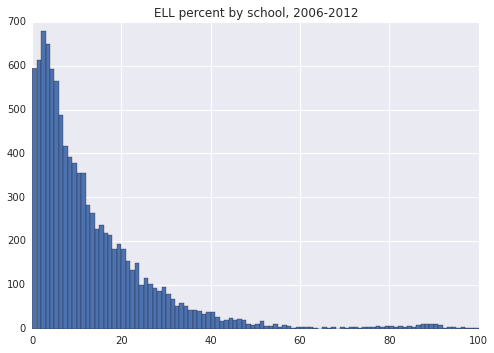

In [130]:
plt.close('all')
ell = plt.hist(demo_and_account['ell_percent'], bins = 100, range=[0,100])
plt.title('ELL percent by school, 2006-2012')

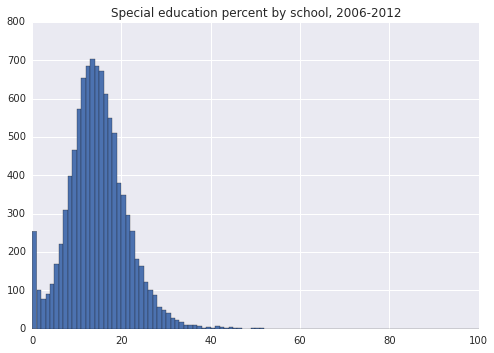

In [131]:
plt.close('all')
sped = plt.hist(demo_and_account['sped_percent'], bins = 100, range=[0,100])
plt.title('Special education percent by school, 2006-2012')

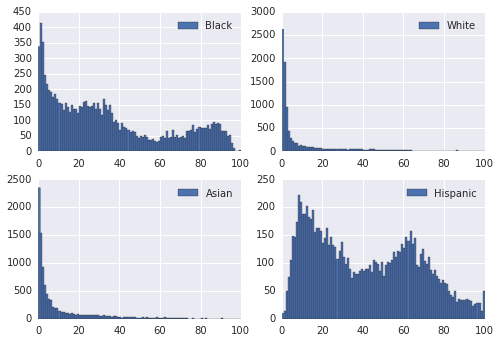

In [132]:
plt.close('all')

plt.figure()
plt.subplot(221)
plt.hist(demo_and_account['black_per'], bins = 100, range=[0,100],label='Black')
plt.legend()

plt.subplot(222)
plt.hist(demo_and_account['white_per'], bins = 100, range=[0,100],label='White')
plt.legend()

plt.subplot(223)
plt.hist(demo_and_account['asian_per'], bins = 100, range=[0,100],label='Asian')
plt.legend()

plt.subplot(224)
plt.hist(demo_and_account['hispanic_per'], bins = 100, range=[0,100],label='Hispanic')
plt.legend()


Finally, let's write this cleaned data to a file so we can merge it into our final dataset.

In [133]:
demo_and_account.to_csv('../../data/clean_demo_account.csv')